In [1]:
#Extracting file

import os
import zipfile

with zipfile.ZipFile('Alzheimer.zip', 'r') as zip_file:
    zip_file.extractall("./")

In [2]:
#DenseNet121 is used

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
path_train = "/content/Alzheimer_s Dataset/train"
path_test = "/content/Alzheimer_s Dataset/test"

train_rescale = ImageDataGenerator(rescale=1./255)
test_rescale = ImageDataGenerator(rescale=1./255)

train_data = train_rescale.flow_from_directory(
    path_train,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)


test_data = test_rescale.flow_from_directory(
    path_test,
    target_size=(224, 224),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='sparse'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
# Load the DenseNet121 model without the top layers
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 1))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)  # For multi-class classification

# Define the full model
densenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
densenet_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history = densenet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=10  # Adjust the number of epochs as needed
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.5877 - loss: 0.9055 - val_accuracy: 0.5004 - val_loss: 1.2746
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 50s 311ms/step - accuracy: 0.7354 - loss: 0.6275 - val_accuracy: 0.5004 - val_loss: 6.4716
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.8852 - loss: 0.3166 - val_accuracy: 0.5004 - val_loss: 5.0362
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 50s 307ms/step - accuracy: 0.9298 - loss: 0.1909 - val_accuracy: 0.5035 - val_loss: 2.1251
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 314ms/step - accuracy: 0.9438 - loss: 0.1579 - val_accuracy: 0.5340 - val_loss: 2.1363
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 50s 307ms/step - accuracy: 0.9700 - loss: 0.0936 - val_accuracy: 0.4058 - val_loss: 5.0286
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 315ms/step - accuracy: 0.9730 - loss: 0.0796 - val_accuracy: 0.2056 - val_loss: 3.5708
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - accuracy: 0.9887 - loss: 0.0

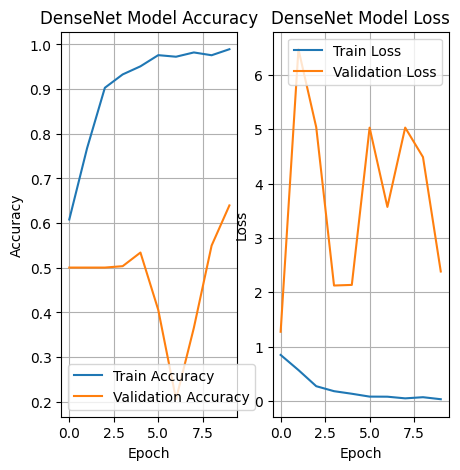

In [8]:
# Plot the training history
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DenseNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
test_loss, test_acc = densenet_model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6517 - loss: 2.2625
Test Loss: 2.382584571838379
Test Accuracy: 0.6395621299743652


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the classes on the test set
predictions = densenet_model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys())
print(class_report)

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step
[[  1   0  92  86]
 [  0   0   7   5]
 [  6   0 335 299]
 [  2   0 225 221]]
                  precision    recall  f1-score   support

    MildDemented       0.11      0.01      0.01       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.51      0.52      0.52       640
VeryMildDemented       0.36      0.49      0.42       448

        accuracy                           0.44      1279
       macro avg       0.25      0.26      0.24      1279
    weighted avg       0.40      0.44      0.41      1279

